In [1]:
import cv2
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt 
import numpy as np
import time
from torch.autograd import Variable

In [2]:
#Transform for trainset and val set
transform_train = transforms.Compose([transforms.Resize(32),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

transform_val = transforms.Compose([transforms.Resize(32),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [3]:
#Load data
train_set = datasets.ImageFolder(root='./data/train', transform=transform_train)
val_set = datasets.ImageFolder(root='./data/val', transform=transform_val)

batch_size = 32

train_load = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
val_load = torch.utils.data.DataLoader(dataset=val_set, batch_size=batch_size, shuffle=True)

In [4]:
print('Train_set:', len(train_set))
print('Validation_set:', len(val_set))
print("Total:", len(train_set) + len(val_set))

Train_set: 19166
Validation_set: 4789
Total: 23955


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


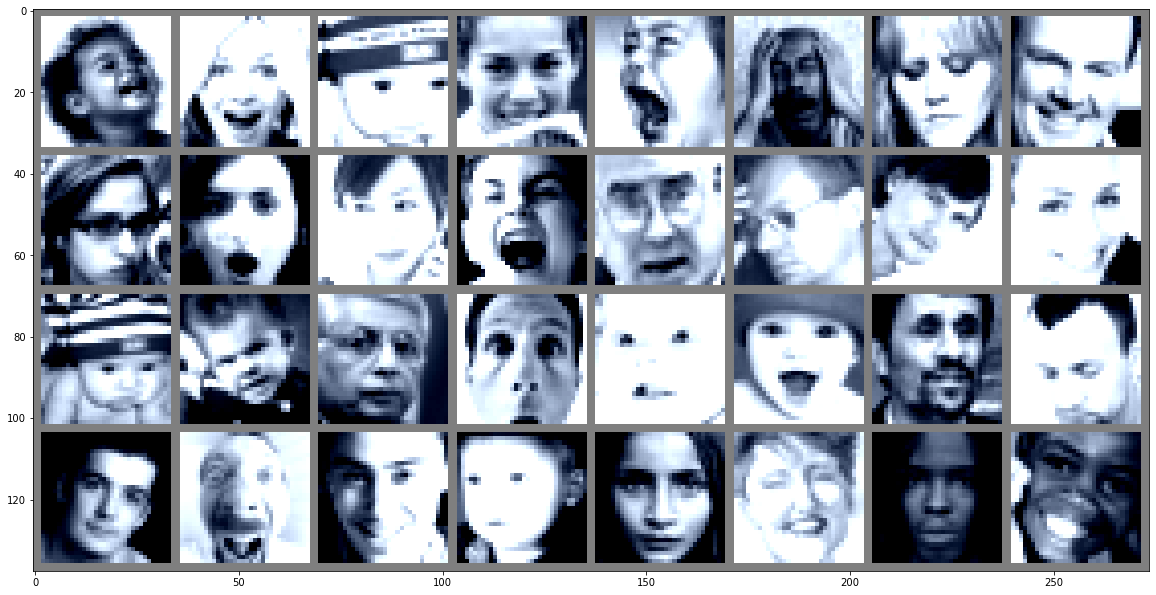

In [5]:
#Show image in a batch
def imgshow(img):
    img = img/2 + 0.5 
    np_img = img.numpy()
    plt.figure(figsize=(20, 20))
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

data_iter = iter(train_load)
img, labels = data_iter.next()
imgshow(torchvision.utils.make_grid(img))

In [6]:
#Define model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        #Feature extract
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2) #16


        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2) #8

        #FC
        self.fc1 = nn.Linear(in_features=4096, out_features=1024) #8x8x64
        self.relu = nn.ReLU()
        self.dropout_fc1 = nn.Dropout(p=0.5)

        self.fc2 = nn.Linear(in_features=1024, out_features=5)


    def forward(self, x):
        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.relu(out)
        out = self.maxpool1(out)

        out = self.conv3(out)
        out = self.relu(out)
        out = self.conv4(out)
        out = self.relu(out)
        out = self.maxpool2(out)
      
        #Flatten()
        out = out.view(-1, 4096) # 6x6x128 = 4608

        #FC 1
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout_fc1(out)

        #Out
        out = self.fc2(out)

        return out

In [7]:
#Sumary model
model = CNN()
model = model.cuda()
print(model)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (dropout_fc1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1024, out_features=5, bias=True)
)


In [8]:
train_loss = []
val_loss = []
train_acc = []
val_acc = []

def Training_Model(model, epochs, parameters):
    #Using CrossEntropyLoss, optim SGD
    loss_f = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(parameters, lr=0.07, weight_decay=0.00001)

    model = model.cuda()
    
    for epoch in range(epochs): 
        start = time.time()
        correct = 0
        iterations = 0
        iter_loss = 0.0
        
        model.train() #Set mode Train                  
        
        for i, (inputs, labels) in enumerate(train_load, 0):
            inputs = Variable(inputs)
            labels = Variable(labels)
            
            #Convert to Cuda() to use GPU
            inputs = inputs.cuda()
            labels = labels.cuda()
            
            optimizer.zero_grad()  
            
            #Forward
            outputs = model(inputs)
            
            #Calculating loss
            loss = loss_f(outputs, labels)  
            iter_loss += loss.item()
            
            #Backpropagation
            loss.backward()              
            optimizer.step()             
            
            # Record the correct predictions for training data 
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum()
            iterations += 1
    

        train_loss.append(iter_loss/iterations)
        train_acc.append((100 * correct / len(train_set)))
   

        #Eval on validation set
        loss = 0.0
        correct = 0
        iterations = 0

        model.eval() #Set mode evaluation

        #No_grad on Val_set
        with torch.no_grad():
            for i, (inputs, labels) in enumerate(val_load, 0):
                
                inputs = Variable(inputs)
                labels = Variable(labels)
                
                #To Cuda()
                inputs = inputs.cuda()
                labels = labels.cuda()
                
                #Forward and Caculating loss
                outputs = model(inputs)     
                loss = loss_f(outputs, labels) 
                loss += loss.item()

                # Record the correct predictions for val data
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum()
                iterations += 1

            val_loss.append(loss/iterations)
            val_acc.append((100 * correct / len(val_set)))

        stop = time.time()
        
        print ('Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}, Val Loss: {:.3f}, Val Accuracy: {:.3f}, Time: {}s'
            .format(epoch+1, epochs, train_loss[-1], train_acc[-1], val_loss[-1], val_acc[-1],stop-start))

In [9]:
epochs = 32
Training_Model(model=model, epochs=epochs, parameters=model.parameters())

Epoch 1/32, Training Loss: 1.501, Training Accuracy: 32.000, Val Loss: 0.020, Val Accuracy: 40.000, Time: 22.069555044174194s
Epoch 2/32, Training Loss: 1.337, Training Accuracy: 43.000, Val Loss: 0.016, Val Accuracy: 46.000, Time: 18.0090274810791s
Epoch 3/32, Training Loss: 1.213, Training Accuracy: 49.000, Val Loss: 0.012, Val Accuracy: 54.000, Time: 18.47557783126831s
Epoch 4/32, Training Loss: 1.115, Training Accuracy: 54.000, Val Loss: 0.017, Val Accuracy: 54.000, Time: 16.68022847175598s
Epoch 5/32, Training Loss: 1.034, Training Accuracy: 58.000, Val Loss: 0.014, Val Accuracy: 58.000, Time: 16.45400309562683s
Epoch 6/32, Training Loss: 0.976, Training Accuracy: 60.000, Val Loss: 0.015, Val Accuracy: 61.000, Time: 16.399189233779907s
Epoch 7/32, Training Loss: 0.921, Training Accuracy: 63.000, Val Loss: 0.012, Val Accuracy: 61.000, Time: 16.397119760513306s
Epoch 8/32, Training Loss: 0.870, Training Accuracy: 65.000, Val Loss: 0.010, Val Accuracy: 62.000, Time: 16.42607712745666

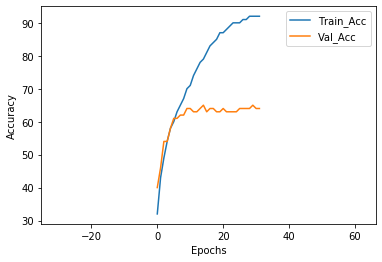

In [10]:
import matplotlib.pyplot as plt

plt.plot(train_acc, label='Train_Acc')
plt.plot(val_acc, label='Val_Acc')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.axis('equal')
plt.legend();